SVM - Experience Level Prediction

In [20]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
warnings.filterwarnings('ignore')
print('Kütüphaneler yüklendi.')

Kütüphaneler yüklendi.


In [21]:
# [1] Data Load
try:
    df = pd.read_csv('gym_members_exercise_tracking.csv')
    print(f"Veri yüklendi. Row: {df.shape[0]}, Column: {df.shape[1]}")
except FileNotFoundError:
    print("Hata: 'gym_members_exercise_tracking.csv' dosyası bulunamadı.")

Veri yüklendi. Row: 973, Column: 15



============================== EDA ==============================
EDA Görselleri kaydedildi (eda_plots.png, correlation_heatmap.png).


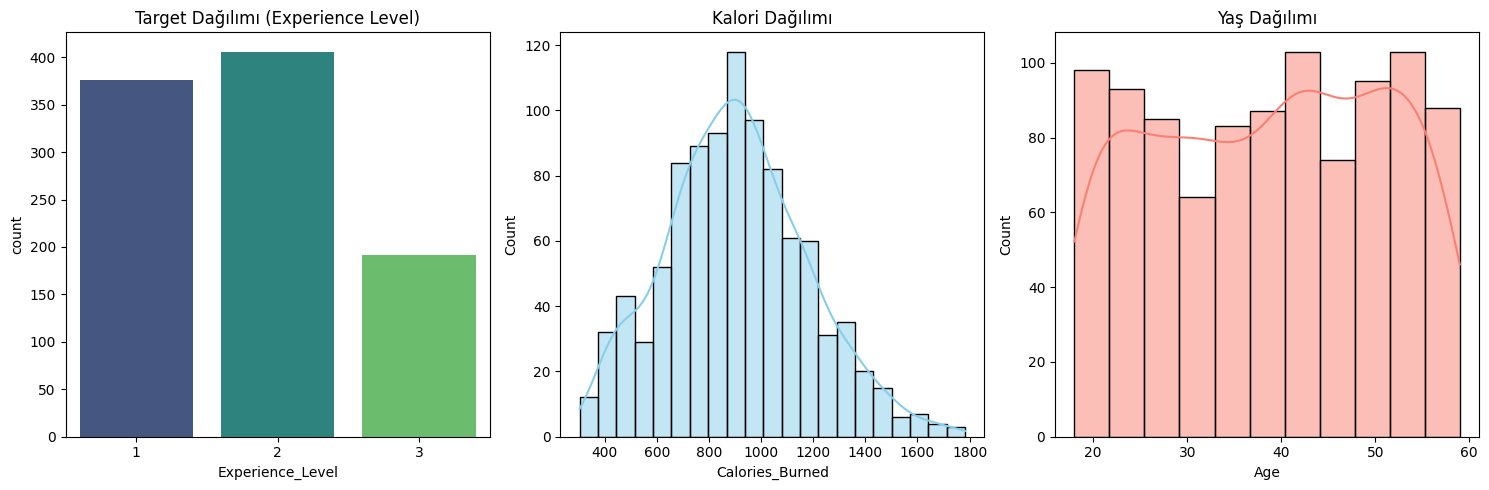

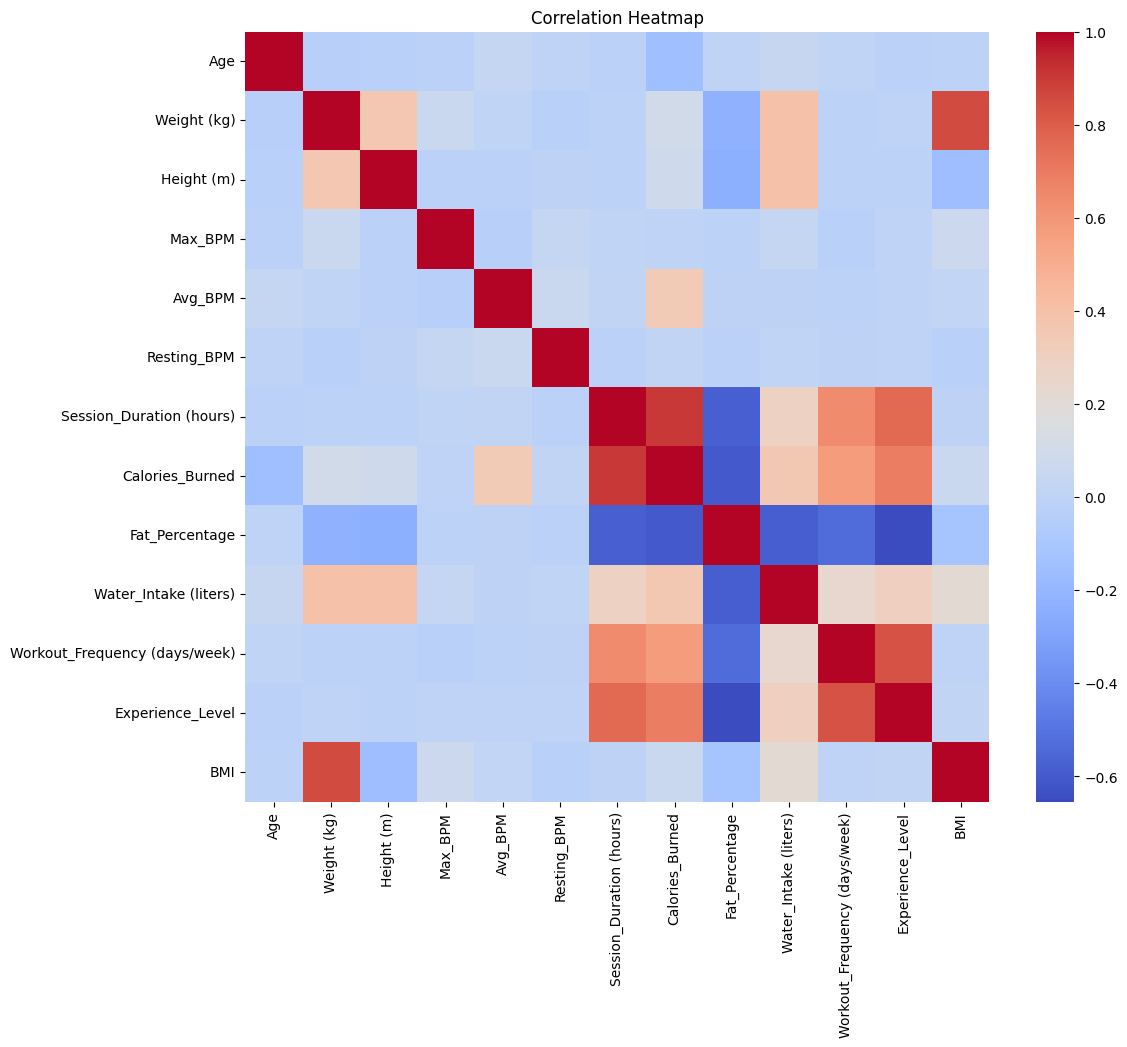

In [22]:
# [2] EDA (Exploratory Data Analysis)
print("\n" + "="*30 + " EDA " + "="*30)
plt.figure(figsize=(15, 5))

# Target Dağılımı
plt.subplot(1, 3, 1)
sns.countplot(x='Experience_Level', data=df, palette='viridis')
plt.title('Target Dağılımı (Experience Level)')

# Histogram: Örnek olarak Calories_Burned
plt.subplot(1, 3, 2)
sns.histplot(df['Calories_Burned'], kde=True, color='skyblue')
plt.title('Kalori Dağılımı')

# Histogram: Örnek olarak Age
plt.subplot(1, 3, 3)
sns.histplot(df['Age'], kde=True, color='salmon')
plt.title('Yaş Dağılımı')
plt.tight_layout()
plt.savefig('eda_plots.png')

# Correlation Heatmap (Sadece sayısal sütunlar)
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
print("EDA Görselleri kaydedildi (eda_plots.png, correlation_heatmap.png).")

In [23]:
# [3] Feature Engineering
df['HR_per_minute'] = df['Avg_BPM'] / (df['Session_Duration (hours)'] * 60)
df['Intensity_per_Weight'] = df['Calories_Burned'] / df['Weight (kg)']
df['HRR'] = df['Max_BPM'] - df['Resting_BPM']
df['Efficiency'] = df['Calories_Burned'] / df['Avg_BPM']
df['Anaerobic_Index'] = (df['Max_BPM'] - df['Avg_BPM']) / df['Resting_BPM']
df['BPM_Variance_Rest'] = (df['Avg_BPM'] - df['Resting_BPM']) ** 2
df['Heart_Instability'] = abs(df['Max_BPM'] - df['Avg_BPM']) / df['Max_BPM']
df['Calories_per_Hour'] = df['Calories_Burned'] / df['Session_Duration (hours)']
df['Heart_Efficiency'] = df['Calories_Burned'] / df['HRR']
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)
df['Workout_Intensity'] = df['Calories_Burned'] * df['Max_BPM'] / 1000
df['Performance_Score'] = df['Calories_Burned'] * df['Workout_Frequency (days/week)']
df['Fitness_Level'] = df['HRR'] / df['Resting_BPM']
df['Training_Load'] = df['Session_Duration (hours)'] * df['Workout_Frequency (days/week)'] * df['Avg_BPM']

# Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()
df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])
df['Workout_Type_Encoded'] = le_workout.fit_transform(df['Workout_Type'])

# Feature Selection
feature_cols = [
    'Age', 'Gender_Encoded', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Frequency (days/week)',
    'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Type_Encoded', 'BMI',
    'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability',
    'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group',
    'Workout_Intensity', 'Performance_Score', 'Fitness_Level', 'Training_Load'
]
X = df[feature_cols]
y = df['Experience_Level']
print(f'Features: {X.shape[1]}')

Features: 29


In [24]:
# [4] Train / Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Veri bölündü ve StandardScaler uygulandı.")

Train: 681, Test: 292
Veri bölündü ve StandardScaler uygulandı.


In [25]:
# [5] Model Training (Baseline, Tuned, CV)
print("\n" + "="*30 + " MODEL TRAINING " + "="*30)
# Baseline
print('\n' + '='*70)
print('BASELINE MODEL')
print('='*70)
svm_baseline = SVC(kernel='rbf', random_state=42)
svm_baseline.fit(X_train_scaled, y_train)
print(f'Train: {accuracy_score(y_train, svm_baseline.predict(X_train_scaled)):.4f}')
print(f'Test:  {accuracy_score(y_test, svm_baseline.predict(X_test_scaled)):.4f}')

# Tuned (GridSearchCV)
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1], 'kernel': ['rbf', 'poly']}
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# CV Score
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5)

print(f"\nEn İyi Parametreler: {grid_search.best_params_}")
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f}")


============================== MODEL TRAINING ==============================

BASELINE MODEL
Train: 0.9163
Test:  0.8664

En İyi Parametreler: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Cross-Validation Accuracy: 0.8708



============================== EVALUATION ==============================


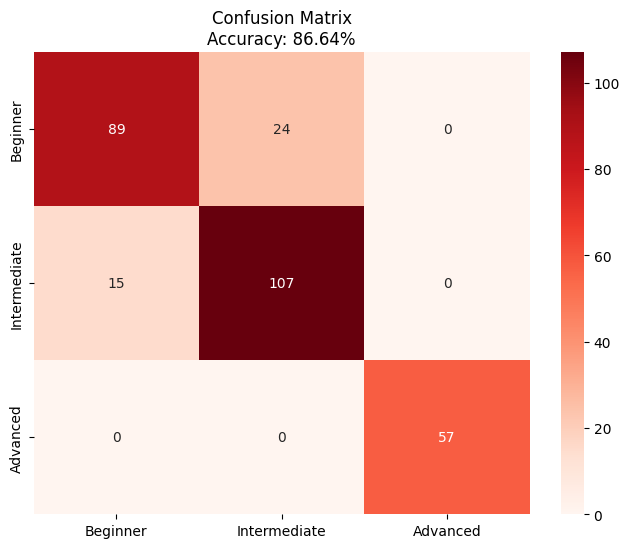

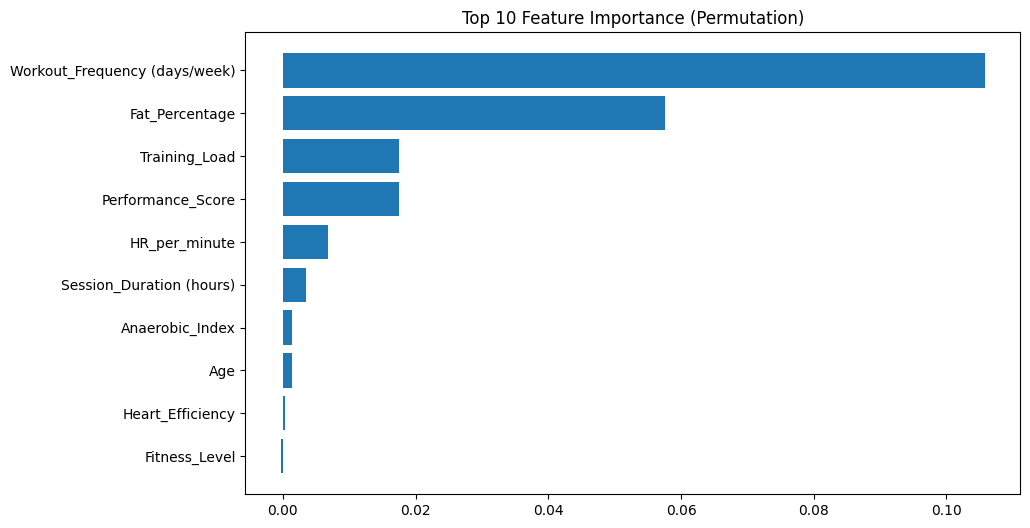

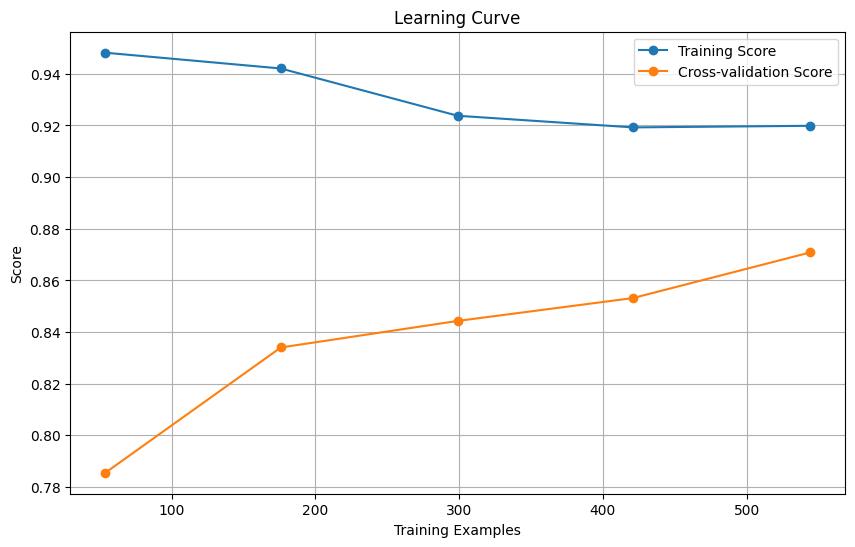

In [26]:
# [6] Evaluation
print("\n" + "="*30 + " EVALUATION " + "="*30)
y_pred = best_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Beginner', 'Intermediate', 'Advanced'],
            yticklabels=['Beginner', 'Intermediate', 'Advanced'])
plt.title(f'Confusion Matrix\nAccuracy: {test_acc:.2%}')
plt.savefig('confusion_matrix.png')

# Feature Importance (Permutation Importance)

# RBF kernel'da katsayılar (coefficients) doğrudan alınamadığı için,
# modelin değişkenlere verdiği önemi anlamak amacıyla Permutation Importance yöntemi kullanılmıştır.
perm_importance = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-10:] # En iyi 10 özellik

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_cols)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Top 10 Feature Importance (Permutation)")
plt.savefig('feature_importance.png')

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation Score")
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig('learning_curve.png')

In [27]:
# [7] Final Conclusions
print("\n" + "="*30 + " FINAL CONCLUSIONS " + "="*30)
print(f"1. Modelin Test Başarısı: {test_acc:.4f}")
print(f"2. Cross-Validation Tutarlılığı: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
print(f"3. En Önemli Özellikler: {np.array(feature_cols)[sorted_idx[-1]]}, {np.array(feature_cols)[sorted_idx[-2]]}")
print("4. Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))


============================== FINAL CONCLUSIONS ==============================
1. Modelin Test Başarısı: 0.8664
2. Cross-Validation Tutarlılığı: 0.8708 (+/- 0.0213)
3. En Önemli Özellikler: Workout_Frequency (days/week), Fat_Percentage
4. Sınıflandırma Raporu:
              precision    recall  f1-score   support

           1       0.86      0.79      0.82       113
           2       0.82      0.88      0.85       122
           3       1.00      1.00      1.00        57

    accuracy                           0.87       292
   macro avg       0.89      0.89      0.89       292
weighted avg       0.87      0.87      0.87       292

